In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import umap
plt.rcParams["font.family"] = "HanaMinA" 

In [4]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [5]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load(topn=3000)

## Load radical permutations

In [6]:
import pickle
with open("../data/exp/radical_cluster_perm.pkl", "rb") as fin:
    perm_results = pickle.load(fin)

In [245]:
def visualize_compo_contrast(target_rads):
    target_characters = []
    target_indices = []
    radical_labels = []
    for ch in lexicon:
        rad = radicals.query(ch)[0]
        if rad not in target_rads or\
           tsvars.is_simplified(ch) or\
           ch not in kv.vocab:
            continue
        target_characters.append(ch)
        target_indices.append(kv.vocab[ch].index)
        radical_labels.append(rad)        
    
    sub_vectors = np.zeros((len(target_indices), kv.vector_size))
    for i, idx in enumerate(target_indices):
        sub_vectors[i, :] = kv.vectors[idx, :]
    # reducer = umap.UMAP(n_neighbors=10)    
    reducer = PCA(2)
    proj = reducer.fit_transform(sub_vectors)
    data = pd.DataFrame(dict(
            pca0=proj[:,0], pca1=proj[:,1],
            radical=radical_labels))
    ax = sns.scatterplot(data=data, x="pca0", y="pca1", hue="radical")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')

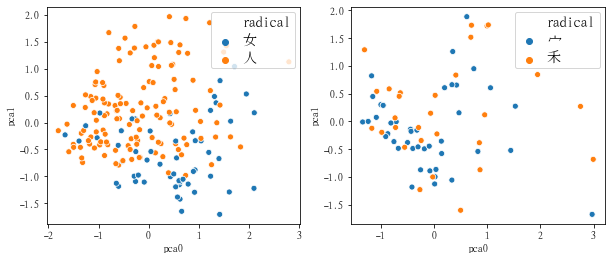

In [246]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
visualize_compo_contrast(["人", "女"])
plt.subplot(1,2,2)
visualize_compo_contrast(["宀", "禾"])

Text(0.5, 1.0, '宀 vs. 禾')

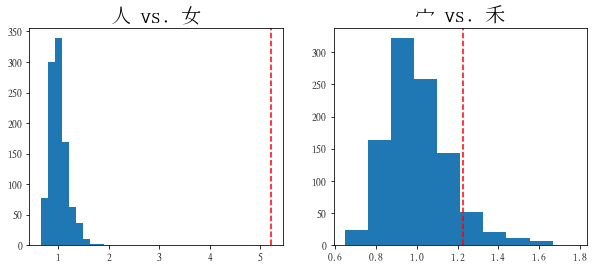

In [248]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(perm_results[("人", "女")]["permutes"])
axes[0].axvline(perm_results[("人", "女")]["estimate"], color="red", linestyle='--')
axes[0].set_title("人 vs. 女", fontsize=20)
axes[1].hist(perm_results[("宀", "禾")]["permutes"])
axes[1].axvline(perm_results[("宀", "禾")]["estimate"], color="red", linestyle='--')
axes[1].set_title("宀 vs. 禾", fontsize=20)

In [7]:
from collections import Counter
radical_freq = Counter(radicals.query(x)[0] for x in lexicon if not tsvars.is_simplified(x))

In [8]:
radical_freq.most_common(25)[-5:]

[('阜', 34), ('玉', 33), ('目', 32), ('石', 29), ('禾', 29)]

In [9]:
[(k[0], radical_freq[k[0]], k[1], radical_freq[k[1]]) for k, v in perm_results.items() if v["pvalue"] > 0.001]

[('水', 162, '禾', 29),
 ('人', 133, '宀', 43),
 ('人', 133, '刀', 35),
 ('人', 133, '阜', 34),
 ('人', 133, '禾', 29),
 ('玉', 33, '艸', 97),
 ('辵', 67, '阜', 34),
 ('禾', 29, '辵', 67),
 ('土', 65, '石', 29),
 ('土', 65, '禾', 29),
 ('宀', 43, '日', 49),
 ('日', 49, '禾', 29),
 ('宀', 43, '阜', 34),
 ('宀', 43, '禾', 29),
 ('刀', 35, '阜', 34),
 ('刀', 35, '竹', 34),
 ('刀', 35, '石', 29),
 ('刀', 35, '禾', 29),
 ('禾', 29, '阜', 34),
 ('石', 29, '竹', 34),
 ('禾', 29, '竹', 34)]

In [10]:
to_exclude = lambda x: any(y in "禾阜宀刀" for y in x)
[(k[0], radical_freq[k[0]], k[1], radical_freq[k[1]]) 
     for k, v in perm_results.items() 
     if v["pvalue"] > 0.005 and not to_exclude(k)]

[]

In [24]:
from itertools import chain
selected_radicals = set(chain.from_iterable(perm_results.keys())) - set("禾阜宀刀")
selected_radicals = sorted(selected_radicals, key=radical_freq.get, reverse=True)

In [25]:
len(selected_radicals)

21

In [26]:
print(selected_radicals)

['水', '手', '人', '口', '木', '艸', '心', '言', '糸', '辵', '土', '肉', '女', '火', '日', '金', '貝', '竹', '玉', '目', '石']


In [27]:
len(lexicon)

4024

In [28]:
radical_idxmap = {rad: idx for idx, rad in enumerate(selected_radicals)}
radical_vectors = np.zeros((len(radical_idxmap), kv.vector_size), dtype=np.double)
radical_counter = Counter()
for ch in lexicon:
    if tsvars.is_simplified(ch):
        continue
    rad = radicals.query(ch)[0]
    rad_idx = radical_idxmap.get(rad, -1)
    if rad_idx < 0: continue
    radical_vectors[rad_idx, :] += kv.get_vector(ch)
    radical_counter[rad] += 1
for rad, n in radical_counter.items():
    rad_idx = radical_idxmap[rad]
    radical_vectors[rad_idx] /= radical_counter[rad]
radical_vectors.shape

(21, 300)

In [29]:
la.norm(kv.get_vector("人"))

13.682494713973261

In [250]:
1-3/300

0.99

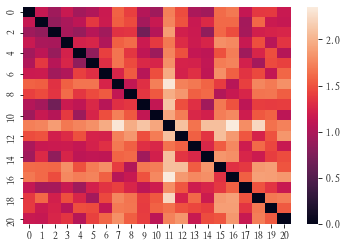

In [30]:
from scipy.spatial.distance import pdist, squareform
# plt.imshow(np.corrcoef(radical_vectors))
sns.heatmap(squareform(pdist(radical_vectors)))

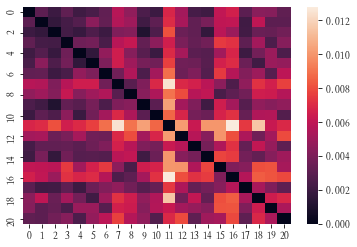

In [31]:
from scipy.spatial.distance import pdist, squareform
# plt.imshow(np.corrcoef(radical_vectors))
sns.heatmap(squareform(pdist(radical_vectors, metric='cosine')))

## Project FastText embeddings into radical space

$$
\begin{align}
\underset{21 \times 300}{R} \cdot \underset{300 \times 21}{X} &= \underset{21 \times 21}{I} \\
X &= R^\top \cdot (RR^{\top})
\end{align}
$$

We can use $X$ to project any vectors from FastText into _radical space_.

$$
\underbrace{v_{\textrm{proj}}}_{21 \times 1} = X^\top \cdot \underbrace{v_{\textrm{fasttext}}}_{300 \times 1}
$$

In [32]:
R = radical_vectors
# the right inverse of R
X = R.T.dot(la.inv(R.dot(R.T)))
X.shape

(300, 21)

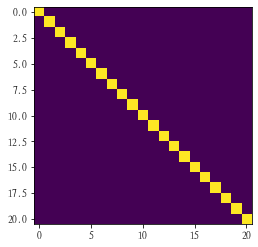

In [33]:
plt.imshow(R.dot(X))

In [177]:
from tabulate import tabulate
def project_radical_bases(ch, vec=None, sort=True, topn=None, return_str=False):
    if vec is None:
        proj_v = kv.get_vector(ch).dot(X)        
    else:
        proj_v = vec.dot(X)
    proj_v /= la.norm(proj_v)
    terms = []
    for i, r in enumerate(selected_radicals):
        terms.append(f"{r} {proj_v[i]:7.4f}")
    terms = sorted(enumerate(terms), key=lambda x: -proj_v[x[0]])
    terms = [x[1] for x in terms]
    if topn:
        terms = terms[:topn]    
    if return_str:
        return terms
    else:
        print("\n".join(terms))

def compare_char_rb(chlist, veclist=None, topn=5):
    if veclist is None:
        ch_terms = {ch: project_radical_bases(ch, topn=topn, return_str=True)
                    for ch in chlist}
    else:
        ch_terms = {ch: project_radical_bases(ch, vec=vec, topn=topn, return_str=True)
                    for ch, vec in zip(chlist, veclist)}
    print(tabulate(ch_terms, headers=chlist, 
                   colalign=["center"]*len(chlist)))

In [269]:
proj_v = kv.get_vector("河").dot(X)
proj_v /= la.norm(proj_v)
for i in range(0, proj_v.size, 5):
    print(f"[{i:2d}]", "".join([f"{r} {w:7.4f}  " for r, w in zip(selected_radicals[i:i+5], proj_v[i:i+5])]))
print("vector length: ", la.norm(proj_v))

[ 0] 水  0.7297  手 -0.1402  人 -0.2307  口  0.1912  木  0.2722  
[ 5] 艸 -0.1847  心 -0.2385  言 -0.0711  糸 -0.0421  辵  0.1042  
[10] 土  0.2635  肉 -0.0058  女  0.0989  火 -0.2569  日 -0.0069  
[15] 金 -0.0813  貝  0.0623  竹 -0.0923  玉  0.0458  目  0.0249  
[20] 石 -0.0917  
vector length:  1.0


In [178]:
compare_char_rb("河打他吃棒草情語線")

    河          打          他          吃          棒          草          情          語          線
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
水  0.7297  手  0.7085  人  0.6519  口  0.6178  木  0.4642  艸  0.8324  心  0.5446  言  0.5360  糸  0.7307
木  0.2722  口  0.3531  辵  0.4491  貝  0.2928  竹  0.2945  竹  0.2368  人  0.4178  口  0.5250  辵  0.3717
土  0.2635  石  0.2661  玉  0.2398  火  0.2659  口  0.2598  糸  0.1183  辵  0.2859  糸  0.2644  土  0.1232
口  0.1912  日  0.1909  口  0.2275  手  0.2110  玉  0.2563  日  0.1153  女  0.2768  土  0.2252  口  0.1202
辵  0.1042  貝  0.1680  艸  0.1323  肉  0.1359  石  0.1976  心  0.0753  石  0.1795  艸  0.1809  石  0.0991


In [172]:
compare_char_rb("好壞夫婦父母善惡")

    好          壞          夫          婦          父          母          善          惡
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
人  0.5157  心  0.5643  人  0.6616  女  0.6651  人  0.4402  女  0.5025  心  0.4494  心  0.4517
口  0.4945  口  0.3516  艸  0.3888  言  0.2409  木  0.3358  人  0.4909  木  0.4179  口  0.4389
日  0.2073  糸  0.3154  土  0.3065  糸  0.1874  辵  0.2629  木  0.3279  玉  0.3407  言  0.4091
女  0.1441  手  0.2515  糸  0.1534  水  0.1856  女  0.2240  糸  0.1717  人  0.2256  糸  0.2426
竹  0.1366  石  0.1448  玉  0.1001  火  0.1620  竹  0.1779  辵  0.1092  水  0.2082  木  0.1573


In [173]:
compare_char_rb("老小生死陰陽")

    老          小          生          死          陰          陽
----------  ----------  ----------  ----------  ----------  ----------
人  0.5604  人  0.7108  女  0.4355  辵  0.5471  言  0.4906  水  0.5969
土  0.4170  口  0.3120  日  0.3464  心  0.4941  女  0.2970  日  0.4478
火  0.2756  竹  0.2026  艸  0.3150  女  0.2194  水  0.2458  木  0.2407
口  0.2569  糸  0.1654  辵  0.3113  土  0.1809  肉  0.2348  言  0.1863
艸  0.2252  木  0.1409  人  0.3016  肉  0.1739  糸  0.2130  糸  0.1145


## Compare component by radical bases

In [174]:
with open("../data/exp/compo_vectors.pkl", "rb") as fin:
    dat = pickle.load(fin)
    compo_ft = dat["compovec"]
    compo_labels = dat["components"]

In [180]:
def query_component(compo, is_trad=None):
    if is_trad is not None:
        compo = compo + ("_t" if is_trad else "_s")
    compo_vec = compo_ft[compo_labels.index(compo)]
    return compo_vec

In [197]:
# ctree.query(tsvars.convert("戀")[0], max_depth=1, use_flag="shortest")
ctree.query("戀", max_depth=1, use_flag="shortest")

[<⿱:['䜌']['心']>]

In [185]:
target_compos = ["女_t", "女_s", "言_t", "讠_s"]
compare_char_rb(chlist=target_compos, 
                veclist=[query_component(x) for x in target_compos])

   女_t        女_s        言_t        讠_s
----------  ----------  ----------  ----------
女  0.8438  女  0.6755  言  0.9069  言  0.5190
目  0.1936  目  0.2998  目  0.1297  人  0.3818
言  0.1255  心  0.2271  心  0.0862  目  0.3319
心  0.1142  火  0.1585  貝  0.0688  心  0.3094
玉  0.1138  土  0.1507  土  0.0610  土  0.1373


In [198]:
target_compos = ["䜌_t", "亦_t", "亦_s"]
compare_char_rb(chlist=target_compos, 
                veclist=[query_component(x) for x in target_compos])

   䜌_t        亦_t        亦_s
----------  ----------  ----------
言  0.4055  心  0.4540  心  0.3374
糸  0.3936  言  0.2909  女  0.3232
女  0.3673  金  0.2883  糸  0.2964
口  0.0990  石  0.2784  土  0.2900
肉  0.0766  辵  0.2302  手  0.2525


In [206]:
compare_char_rb("女言亦重")

    女          言          亦          重
----------  ----------  ----------  ----------
女  0.8009  言  0.6892  人  0.8378  辵  0.5141
木  0.2247  木  0.2736  辵  0.3742  人  0.5061
人  0.1588  人  0.2664  心  0.0946  木  0.3416
竹  0.1451  心  0.2631  日  0.0784  糸  0.2167
辵  0.1143  手  0.1014  肉  0.0435  艸  0.1928


In [218]:
compare_char_rb("鼠牛虎兔龍蛇")

    鼠          牛          虎          兔          龍          蛇
----------  ----------  ----------  ----------  ----------  ----------
口  0.5181  人  0.5913  木  0.4142  口  0.6521  金  0.4493  目  0.5230
肉  0.4094  艸  0.3218  目  0.3888  目  0.2246  土  0.3466  艸  0.2637
竹  0.3951  土  0.2798  人  0.3667  木  0.1840  木  0.2530  肉  0.2627
艸  0.2581  貝  0.2442  辵  0.2361  艸  0.1759  辵  0.2068  人  0.2483
木  0.2405  火  0.2178  金  0.2359  貝  0.1745  肉  0.1912  木  0.2335
